In [28]:
import numpy as np
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle



In [29]:
train_df = pd.read_csv('archive/train.csv',sep=" ",header=None)
train_df.columns=['patient id', 'filename', 'label','data source']
train_df=train_df.drop(['patient id', 'data source'], axis=1 )
train_df.head()

,filename,label
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [30]:
test_df = pd.read_csv('archive/test.csv',sep=" ",header=None)
test_df.columns=['patient id', 'filename', 'label','data source']
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
test_df.head()

,filename,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [31]:
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())
train_df = shuffle(train_df)


positive    15994
negative    13992
Name: label, dtype: int64
positive    200
negative    200
Name: label, dtype: int64


In [32]:
imagePath = 'archive'

def remove_corrupt(path):
    corrupt = 0
    removed_filenames = []
    folder_name = 'train'
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            corrupt += 1
            removed_filenames.append(fname)
            # Drop corrupted image
            #os.remove(fpath)
    print(f'Total %d corrupt images in {folder_name} dataset: ' % corrupt)
    print('All corrupt images dropped.' + '\n')
    return removed_filenames


removed_image_filenames = remove_corrupt(imagePath)

#create new DataFrames that exclude the removed filenames using the ~ operator to invert a boolean mask:
train_df_filtered = train_df[~train_df['filename'].isin(removed_image_filenames)]
train_df_filtered.head




Total 15961 corrupt images in train dataset: 
All corrupt images dropped.



<bound method NDFrame.head of                                                 filename     label
17493  A223205-01-06-1901-NA-CHEST_AP_PORT-75723-2.00...  positive
20556  A385150-12-28-1900-NA-CHEST_AP_PORT-83261-1.00...  positive
16447  A680897-01-18-1901-NA-CHEST_AP_PORT-55585-5.00...  positive
370                      aspiration-pneumonia-5-day0.jpg  negative
24509  A630027-12-31-1900-NA-CHEST_AP_VIEWONLY-56133-...  positive
...                                                  ...       ...
24786  A953733-01-05-1901-NA-CHEST_AP_PORT-59661-2.00...  positive
17155  A416909-02-27-1901-NA-CHEST_AP_PORT-81465-1.00...  positive
21679  A558243-01-15-1901-NA-CHEST_AP_PORT-40634-4.00...  positive
28446  A880343-01-07-1901-NA-CHEST_AP_PORT-60809-1.00...  positive
23613  A528910-12-25-1900-NA-CHEST_AP_PORT-39711-1.00...  positive

[14025 rows x 2 columns]>

In [33]:
#Let's see how many images for training and validation and testing
train_df_filtered, valid_df = train_test_split(train_df_filtered, train_size=0.8, random_state=0)

print(f"Negative and positive values of train:\n {train_df_filtered['label'].value_counts()}")
print(f"Negative and positive values of validation:\n {valid_df['label'].value_counts()}")
print(f"Negative and positive values of test:\n {test_df['label'].value_counts()}")

Negative and positive values of train:
 positive    11041
negative      179
Name: label, dtype: int64
Negative and positive values of validation:
 positive    2758
negative      47
Name: label, dtype: int64
Negative and positive values of test:
 positive    200
negative    200
Name: label, dtype: int64


Found 29986 validated image filenames belonging to 2 classes.
Found 2805 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
f5e587fa-9b99-4e6f-a0f6-b510bdad6183.png 1.0


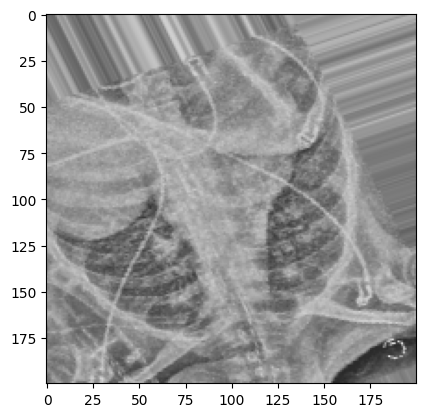

In [34]:


train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory='archive/train', x_col='filename', 
                                              y_col='label', target_size=(200,200), batch_size=64, 
                                               class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory='archive/train', x_col='filename',
                                             y_col='label', target_size=(200,200), batch_size=64, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory='archive/test', x_col='filename', 
                                            y_col='label', target_size=(200,200), batch_size=64,
                                             class_mode='binary')

#class mode binary because we want the classifier to predict covid or not
#target size (200,200) means we want the images to resized to 200*200

#Examine the first image in the training dataset and print the label which corresponding to it.
images, labels = next(train_gen)
# Get the filenames associated with the images in the batch
filenames = train_gen.filenames
# Print the filename and label for the first image in the batch
print(filenames[0], labels[0])
# Plot the first image in the batch
plt.imshow(images[0])